# Notebook to Generate, Save, Load, and Fit Synthetic Spitzer Light Curves of Transiting Planets
## Coded by: Joel C. Schwartz — Postdoc, McGill University
## Last Updated: 02/22/17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pat
%matplotlib inline

import Ver8_Mock_Spitzer_Definitions as MSD  # File where I'm keeping all the functions needed from now on

import emcee
import corner

from scipy.interpolate import RectBivariateSpline
from scipy.integrate import quad

pi = np.pi

# Setup the Planetary System & Light Curve

In [2]:
Generate_key = True  # True to generate from scratch; False to load a data set that's already made
ExportLC_key = False  # True to save generated light (if generate key is also turned on)

folder_Name = 'V8_LC_Info/'
loadfile_Name = 'Test_Scenario_001'

## Input Values — Edit these if generating
#### Some bogus combos won't work: for example, if the planet has a bigger radius than the star

In [25]:
if Generate_key == True:
    
    ## Planetary System
    Star_mass = 1.0  # Solar masses
    Star_radius = 1.0  # Solar radii
    Star_Teff = 5778  # Kelvin

    Planet_semimajor = 0.05  # AU
    Planet_radius = 5.0  # Jupiter radii: NEPTUNE would be about 0.3464, EARTH would be about 0.0892
    Planet_impact = 0.0 # Impact parameter: [0,1]

    Planet_Ag = 0.3  # Geometric albedo: [0,1.5]  — this is in whatever waveband is defined below
    Planet_AB = 0.2  # Bond albedo: [0,1]
    Planet_varepsilon = 0.35  # Heat recirculation efficiency: [0,1]


    ## Light Curve
    NperHr = 120  # Cadence of data, in points per hour
    Obs_orbits = 1.5  # How many orbits did you observe? Can be fractional and/or less than 1
    Frac_transinone = 0.75  # Time-fraction into 1ST OBSERVED ORBIT that transit happens (i.e. timing for everything)

    wavelength_Obs = 4.5  # 'Bolo' for bolometric, OR center of waveband in microns
    bandwidth_Obs = 1.0  # Anything for bolometric, OR full-width of wavelength channel in microns

    significance_decl = 10.0*np.ones(1)  # Significance of the eclipse (i.e. how many sigma is it detected at?)
    ratio_DelD_decl = 10.0*np.ones(1)  # Ratio of Detector Amplitude (in a given part of light curve) to Eclipse Depth


    ## Repoints, Centroids, Noise
    Frac_repoints = np.array([0,1.0]) # Time-fraction into WHOLE OBSERVATION repoints happen: MUST HAVE 0 and 1.0

    Noisy_cents_key = True  # Add some noise to centroids
    Frac_sigcent,Rhomax_cent = 0.01,0.5  # Fraction of centroid cluster for uncertainty; maximum covariance

    level_Vnoise = 0.1  # Uncertainty for noise in pixel sensitivity, relative to standard model being from 0 to 1
    Nzy_per_pix = 10  # Number of 'noisy points' to interpolate from, per pixel AND per axis

    Brown_key = False  # Extra Brownian noise signal
    ratio_Brown_DelD = 1.0*np.ones(1)
    
else:
    
    (Star_mass,Star_radius,Star_Teff,
     Planet_semimajor,Planet_radius,Planet_impact,Planet_Ag,Planet_AB,Planet_varepsilon,
     NperHr,Obs_orbits,Frac_transinone,wavelength_Obs,bandwidth_Obs,significance_decl,ratio_DelD_decl,
     Frac_repoints,Noisy_cents_key,Frac_sigcent,Rhomax_cent,level_Vnoise,Nzy_per_pix,
     Brown_key,ratio_Brown_DelD) = MSD.LCloadGiv(folder_Name,loadfile_Name)

## Calculated Values

In [26]:
## Orbital Period
pln_Porb_days = MSD.planet_P(Planet_semimajor,Star_mass)
pln_Porb_sec = pln_Porb_days*(24*3600)  # Number of days * 24 hr/day * 3600 sec/hr

## Planet Temperatures
pln_Tnought = MSD.planet_Tirrad(Star_Teff,Star_radius,Planet_semimajor)
pln_Tday,pln_Tnight = MSD.planet_Tdaynight(Planet_varepsilon,Planet_AB,pln_Tnought)

## Offset of light curve (1st order)
litecrv_Offdeg = MSD.LC_offdeg(Planet_varepsilon)

## Properties of transit, eclipse, and phase variations
(delta_transit,power_transit,dur_transit_sec,
 delta_eclipse,dur_ineclipse_sec,dur_inegress_sec,
 delta_variations,
 delta_systemflux) = MSD.LC_depths_durations(wavelength_Obs,bandwidth_Obs,
                                             Star_radius,Star_Teff,Planet_semimajor,pln_Porb_days,Planet_impact,
                                             Planet_radius,pln_Tday,pln_Tnight,Planet_Ag,litecrv_Offdeg)

## Time of transit in 1st observed orbit
transit_inone = Frac_transinone*pln_Porb_sec

## Data points per orbit and in whole light curve
NperOrb,N_LC = MSD.pregen_Nvals(NperHr,Obs_orbits,pln_Porb_sec)

## Setting detector amplitude and photon noise, from calculated eclipse depth and chosen properties
setting_Delta_D = ratio_DelD_decl*delta_eclipse
within_ecl_N = int(NperOrb*((dur_ineclipse_sec + 2.0*dur_inegress_sec)/pln_Porb_sec))
ratio_SigF_decl = (within_ecl_N**0.5)/significance_decl  # Photon noise / Eclipse depth == Sqrt[N_ecl] / Signif_ecl
setting_SigF = ratio_SigF_decl*delta_eclipse

## Diagram of the Planetary System

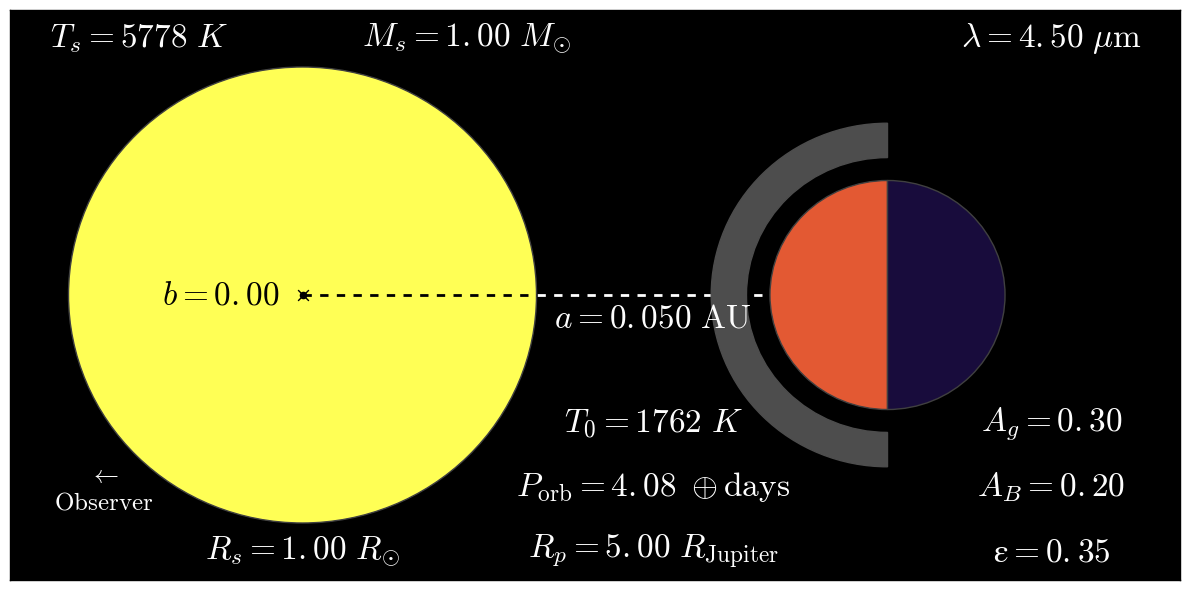

In [27]:
MSD.system_visual(wavelength_Obs,Star_mass,Star_radius,Star_Teff,
                  Planet_semimajor,Planet_radius,Planet_impact,
                  Planet_Ag,Planet_AB,Planet_varepsilon,pln_Porb_days,pln_Tnought,pln_Tday,pln_Tnight)

## Centroids from Telescope Pointing Model
#### More sophisticated: can have multiple repoints now!

In [28]:
temp_time = np.linspace(0,Obs_orbits*pln_Porb_sec,N_LC)  # For 'telescope_pointing' function

if Generate_key == True:
    
    ## Perfect centroids
    (x0_perf,y0_perf,tm_inds,select_point,
     Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals) = MSD.centroiding(temp_time,Frac_repoints)

    ## Noisy centroids (if Noisy_cent_key == True, otherwise same as perfect centroids)
    x0_vals,y0_vals,Cov_true = MSD.centroid_jiggle(Noisy_cents_key,x0_perf,y0_perf,N_LC,Frac_sigcent,Rhomax_cent)

    ## Creating the pixel noise grid to interpolate from
    xgrid_Fixed,ygrid_Fixed,Master_pixNoi = MSD.preNoi_gridding(x0_perf,y0_perf,Nzy_per_pix)
    
else:
    
    (x0_perf,y0_perf,tm_inds,select_point,
     Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals,
     x0_vals,y0_vals,Cov_true,xgrid_Fixed,ygrid_Fixed,Master_pixNoi) = MSD.LCloadCen(folder_Name,loadfile_Name)

## Generate/Load the Light Curve

In [29]:
if Generate_key == True:
    
    ## [amplitude,Porb_planet in sec,phase offset,DC flux offset from 1.0,transit time in 1st observed orbit]
    Ast_true = np.array([0.5*delta_variations,
                         pln_Porb_sec,
                         litecrv_Offdeg*pi/180.0,
                         delta_systemflux,
                         transit_inone])
    ## [half transit duration,power of curve,depth]
    Trans_true = np.array([0.5*dur_transit_sec,
                         power_transit,
                         delta_transit])
    ## [half in-eclipse duration,ingress/egress duration,depth]
    Ecl_true = np.array([0.5*dur_ineclipse_sec,
                         dur_inegress_sec,
                         delta_eclipse])
    mu_true = np.array([0.0])  # Basically a legacy term (adds a systematic offset in the photon noise)
    SigF_true = setting_SigF  # Uncertainty of photon noise; already an array from earlier definition

    # GENERATE!!!
    (T,A_m,D_m,F_perf,F_dat,
     V_map,Vx_val,Vy_val) = MSD.real_gen_model(xgrid_Fixed,ygrid_Fixed,Master_pixNoi,
                                               level_Vnoise,setting_Delta_D,tm_inds,select_point,True,
                                               NperOrb,N_LC,Obs_orbits,Ast_true,Trans_true,Ecl_true,
                                               x0_perf,y0_perf,mu_true,SigF_true)

    # Multiplying in Brownian noise, if wanted.
    F_perf,F_dat,Bro_noi = MSD.brown_signal(Brown_key,ratio_Brown_DelD,F_perf,F_dat,A_m,D_m,mu_true,SigF_true,N_LC)
    
else:
    
    (Ast_true,Trans_true,Ecl_true,mu_true,SigF_true,
     T,A_m,D_m,F_perf,F_dat,V_map,Vx_val,Vy_val,Bro_noi) = MSD.LCloadDat(folder_Name,loadfile_Name)

## Plot the light curve and pixel sensitivity maps!

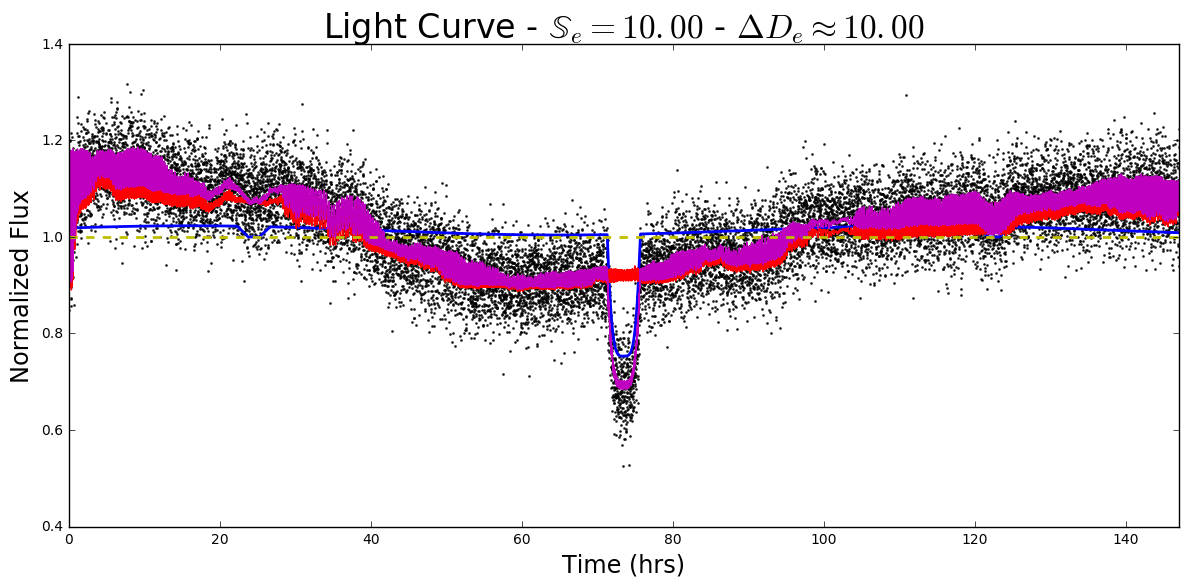

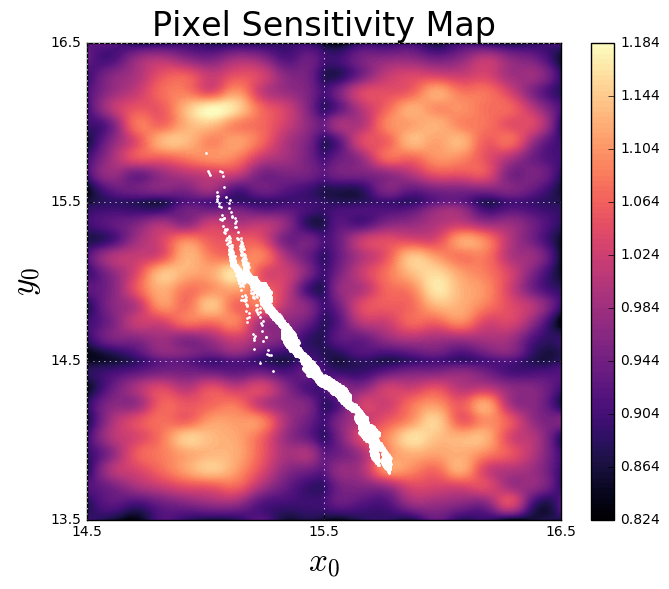

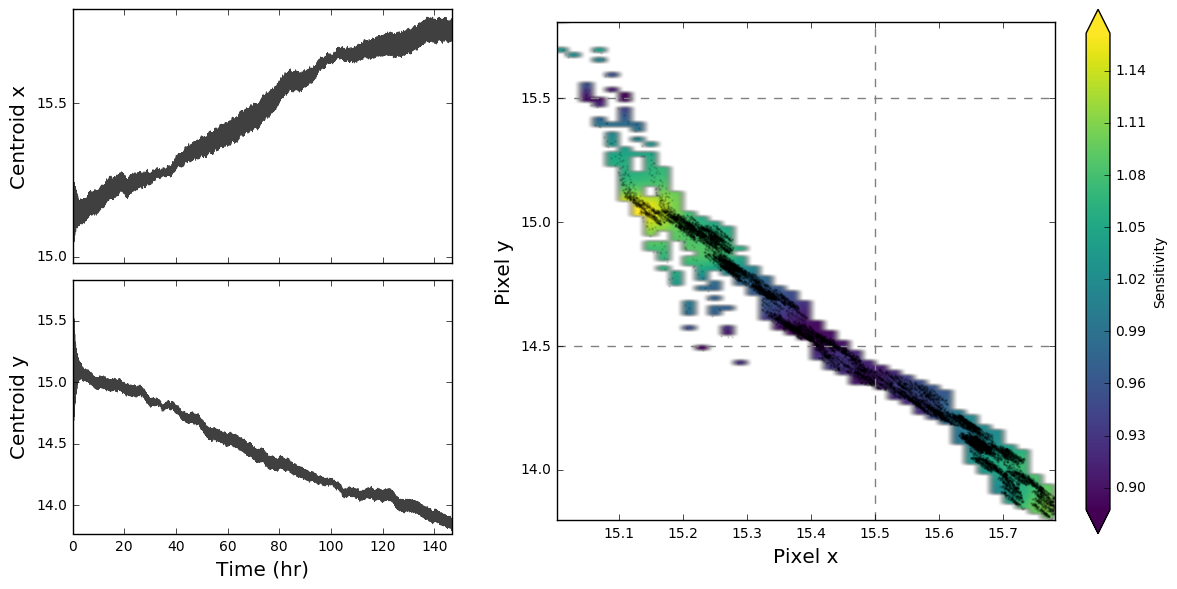

In [32]:
T_viz = T/3600
Blind_data = False # Hide underlying models?
Highlight_astro = False  # If showing: focus on astro model?
Zoom_in = False  # Focus more on phase curve?

MSD.LC_plotter(Blind_data,Highlight_astro,Zoom_in,T_viz,F_dat,A_m,D_m,F_perf,
               Brown_key,Bro_noi,delta_eclipse,significance_decl,ratio_DelD_decl)

MSD.full_pixelsens(Vx_val,Vy_val,V_map,100,x0_perf,y0_perf)  # Number is contours to use

newmap_badmask,lx0,hx0,ly0,hy0 = MSD.cent_mapplot(x0_perf,y0_perf,Vx_val[0,:],Vy_val[:,0])
Smap_bounds = [np.amin(Vx_val),np.amax(Vx_val),np.amin(Vy_val),np.amax(Vy_val)]
minviz,maxviz = np.amin(D_m),np.amax(D_m)

MSD.cent_sensfigs(T_viz,x0_perf,y0_perf,lx0,hx0,ly0,hy0,V_map,newmap_badmask,Smap_bounds,minviz,maxviz)

## Save the light curve data

In [33]:
savefile_Name = 'Test_Scenario_001'

if (Generate_key == True) and (ExportLC_key == True):
    MSD.LCdumpGiv(folder_Name,savefile_Name,Star_mass,Star_radius,Star_Teff,
                  Planet_semimajor,Planet_radius,Planet_impact,Planet_Ag,Planet_AB,Planet_varepsilon,
                  NperHr,Obs_orbits,Frac_transinone,wavelength_Obs,bandwidth_Obs,significance_decl,ratio_DelD_decl,
                  Frac_repoints,Noisy_cents_key,Frac_sigcent,Rhomax_cent,level_Vnoise,Nzy_per_pix,
                  Brown_key,ratio_Brown_DelD)
    MSD.LCdumpCen(folder_Name,savefile_Name,x0_perf,y0_perf,tm_inds,select_point,
                  Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals,
                  x0_vals,y0_vals,Cov_true,xgrid_Fixed,ygrid_Fixed,Master_pixNoi)
    MSD.LCdumpDat(folder_Name,savefile_Name,Ast_true,Trans_true,Ecl_true,mu_true,SigF_true,
                  T,A_m,D_m,F_perf,F_dat,V_map,Vx_val,Vy_val,Bro_noi)
else:
    print('Exporting passed by')

Exporting passed by


# Setup the Models to Fit With

## Polynomial (P-type)

In [34]:
polyO_out = 3

Cn_out = int((polyO_out+2)*(polyO_out+1)/2) - 1
temp_UTout_i = np.triu_indices(polyO_out+1)  # Including constant
UTout_i = (temp_UTout_i[0],polyO_out - temp_UTout_i[1])  # Reflecting to upper-left triangular
C_UTout = np.zeros((polyO_out+1,polyO_out+1))  # Blank coefficient array

cn_out_Vector = np.zeros(Cn_out+1)  # Output poly Cn holder
cn_out_Vector[polyO_out] = 1.0  # Fix the offset term to 1.0

## Standard BLISS (B-type)

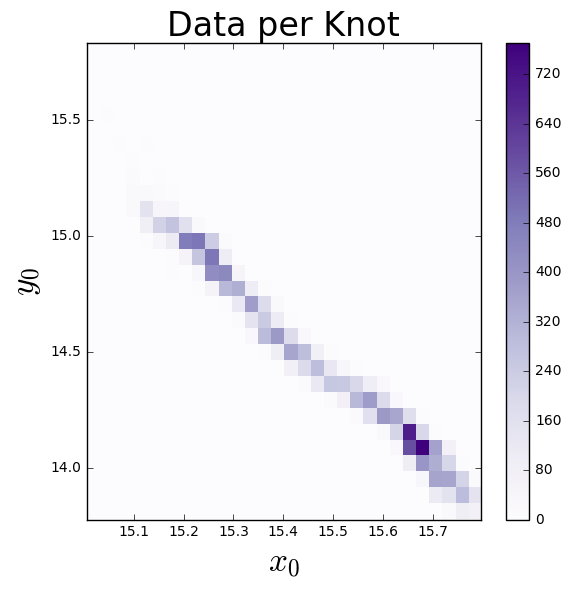

Average Data/Knot = 112.00


In [35]:
N_knots = 30  # Number of BLISS knots to use
all_NNI_key = False  # To only use nearest-neighbor interpolation in the BLISS routine

## Pre-computing BLISS data—knot associations
(low_bx,high_bx,low_by,high_by,x_Knots,y_Knots,
 BK_T,xEdg,yEdg,xKmesh,yKmesh) = MSD.lh_axes_binning(x0_vals,y0_vals,N_knots,N_LC)

NNI,BLS = MSD.which_NNI(all_NNI_key,BK_T,low_bx,high_bx,low_by,high_by)  # Data mask for both methods
delta_xo,delta_yo = x_Knots[1] - x_Knots[0],y_Knots[1] - y_Knots[0]

low_Kx,high_Kx,low_Ky,high_Ky = MSD.lh_bin_to_knot(x_Knots,y_Knots,low_bx,high_bx,low_by,high_by)  # Lower-upper knots
x0_B_i,y0_B_i = MSD.bound_knot(x0_vals,y0_vals,low_bx,high_bx,low_by,high_by,
                                 low_Kx,high_Kx,low_Ky,high_Ky,N_LC)  # Indices of knots bound to data
LL_dst,LR_dst,UL_dst,UR_dst = MSD.bliss_dist(x0_vals,y0_vals,low_Kx,high_Kx,low_Ky,high_Ky)  # BLISS distances


Flux_Bmeth_vec = np.zeros(N_LC)  # Vector to hold detector model in for BLISS routine
xy0_B_lin = x0_B_i + (N_knots*y0_B_i)  # Linear indexing for 'np.bincount' routine


mask_goodBKT = (BK_T != 0.1)  # Mask of knots with at least 1 centroid bound
tot_goodK = np.sum(mask_goodBKT)
print('Average Data/Knot = %.2f' % (N_LC/tot_goodK))

### Example BLISS Detector Signal

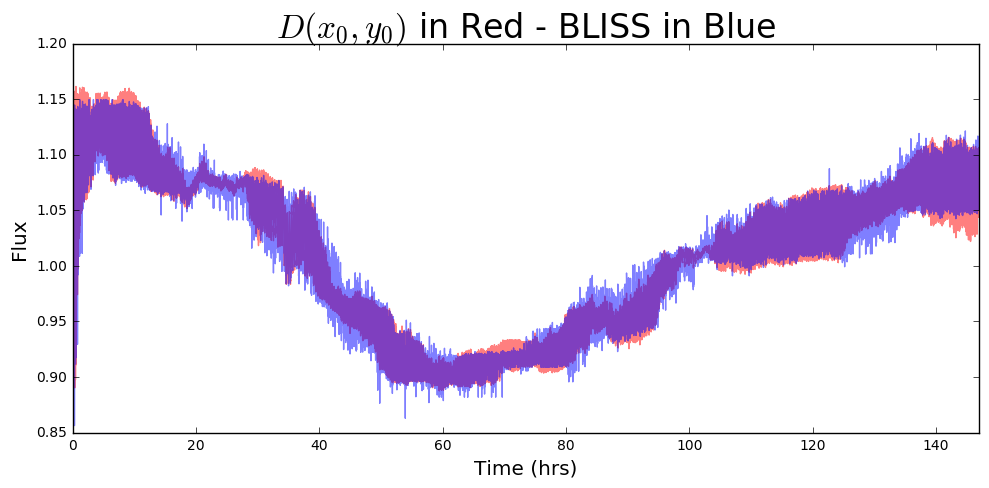

In [36]:
Btype_map = MSD.map_flux_avgQuick(F_dat,A_m,xy0_B_lin,N_knots,BK_T)
Btype_flux = MSD.bliss_meth(N_LC,Flux_Bmeth_vec,Btype_map,x0_vals,y0_vals,delta_xo,delta_yo,x0_B_i,y0_B_i,
                            low_bx,high_bx,low_by,high_by,LL_dst,LR_dst,UL_dst,UR_dst,BLS,NNI)

MSD.examp_Btype_Dm(T_viz,D_m,Btype_flux)

# Setup Priors & EMCEE Walkers

In [37]:
Gauss_key = False  # False uniform, True Gaussian

Real_walk_scale = 1e-3  # Percentage from true values to move 'walker ball' to
Offs_walk_scale = 1e-4  # Percentage of spread within 'walker ball'
Walk_per_dim = 10  # Number of walkers per dimension


## Temporary priors; actual transit_exponent is taken from [1.5,4.0]
if Gauss_key == False:
    pri_ATES = np.array([[100.0*delta_variations,100.0*pln_Porb_sec,pi/2.0,2.0*delta_systemflux,pln_Porb_sec,
                          10.0*dur_transit_sec,4.5,100.0*delta_transit,
                          10.0*dur_transit_sec,10.0*dur_transit_sec,100.0*delta_eclipse,
                          50.0*setting_SigF],
                         [0,0.01*pln_Porb_sec,-pi/2.0,0,0,
                          0,1.0,0,
                          0,0,0,
                          0]])
    pri_PolyCs = np.ones((2,Cn_out))
else:
    pass

## Dimensions, walkers, and initial positions
ndimP,ndimB,nwalkersP,nwalkersB,posP,posB = MSD.dimensions_walkers(Real_walk_scale,Offs_walk_scale,
                                                              Walk_per_dim,Cn_out,
                                                              Ast_true,Trans_true,Ecl_true,SigF_true)
posB[posB == 0] += np.absolute(np.random.randn(len(posB[posB == 0])))  # Don't let walkers cluster at zero!

Prior_P = np.concatenate((pri_ATES,pri_PolyCs),axis=1)
Prior_B = pri_ATES

## Labels for plotting
V_labels,PC_labels = MSD.labeler(polyO_out,Cn_out)

# Setup EMCEE Searching & Plotting

In [ ]:
search_S = 5e2  # Number of steps to search for
pare_S = search_S/50  # Number of steps to check for if walkers have stabilized

Viz_key = True  # Create plots?

## B-type Run

In [ ]:
samplerB = emcee.EnsembleSampler(nwalkersB,ndimB,MSD.data_post,
                                 args=[Gauss_key,Prior_B,T,F_dat,N_LC,NperHr,
                                       xy0_B_lin,N_knots,BK_T,
                                       Flux_Bmeth_vec,x0_vals,y0_vals,delta_xo,delta_yo,x0_B_i,y0_B_i,
                                       low_bx,high_bx,low_by,high_by,LL_dst,LR_dst,UL_dst,UR_dst,BLS,NNI,'B'])
posB,probB,stateB = samplerB.run_mcmc(posB,int(np.around(search_S)));

print('Mean Acceptance Fraction: {0:.5f}'.format(np.mean(samplerB.acceptance_fraction)))
mxcorB = np.amax(samplerB.get_autocorr_time())
print('Highest Autocorrelation Time: %.2f' % mxcorB)

### B-type Plots

In [ ]:
burn_Sb = 0  # Burn-in steps to ignore
Zoom_in == True  # Closer view in AFD-style plots?


if Viz_key == True:
    MSD.walk_style(samplerB.chain,ndimB,burn_Sb,int(np.around(pare_S)),V_labels,PC_labels,
                   Ast_true,Trans_true,Ecl_true,SigF_true,'B')
    MSD.AstTransEcl_corner(samplerB.chain,burn_Sb,int(np.around(mxcorB)),V_labels,
                           Ast_true,Trans_true,Ecl_true,SigF_true)
    MSD.AFD_style(samplerB.chain,burn_Sb,int(np.around(mxcorB)),50,Zoom_in,T,F_dat,F_perf,A_m,D_m,Bro_noi,
                  N_LC,NperHr,
                  xy0_B_lin,N_knots,BK_T,
                  Flux_Bmeth_vec,x0_vals,y0_vals,delta_xo,delta_yo,x0_B_i,y0_B_i,
                  low_bx,high_bx,low_by,high_by,LL_dst,LR_dst,UL_dst,UR_dst,BLS,NNI,'B')